# AN2DL Challenge [2023-2024]
## PolliKungFu Team
### Alessia Marino, Antonino Fabio Coppola, Lorenzo Manoni

# Setup of the project:
Import of libraries, definition of paths

Import of libraries used for the whole project.

In [ ]:
!pip install keras-cv tensorflow
!pip install visualkeras

In [ ]:
import os
import gc
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras import models, callbacks
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import plotly.graph_objects as go
from imblearn.over_sampling import SMOTE
import keras_cv
from tensorflow.data import Dataset
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.utils import plot_model
import visualkeras
from PIL import ImageFont
from sklearn.utils import class_weight

Using TensorFlow backend


In [ ]:
font = ImageFont.load_default()

Defining paths of the project

In [ ]:
master_path = os.path.join("../gdrive/MyDrive/AN2DL Challenge PolliKungFu")
data_path = os.path.join(master_path, "data/")

Mount Drive

In [ ]:
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


## Useful functions

Function for plotting pie charts

In [ ]:
def printPie(y):
    labels = ["Healthy", "Unhealthy"]  # List of labels
    count_0 = np.sum(y == 0)
    count_1 = np.sum(y == 1)
    values = [count_0, count_1]  # List of corresponding values
    text = [f'Healthy: {count_0}', f'Unhealthy: {count_1}']

    fig = go.Figure(data=[go.Pie(labels=labels, values=values, text=text)])
    fig.update_layout(title_text="Pie chart of targets", template="simple_white")
    fig.update_traces(marker=dict(line=dict(color='rgb(0, 0, 0)', width=0.5)))

    fig.show()

Funtions to test the model on validation set and plot the confusion matrix. Confusion Matrix is a really important performance measurement for classification problems: it highliths in which classes the model responds worse and which better.

In [ ]:
def generate_confusion_matrix(model, val_dataset):
    class_names = ['Healthy', 'Unhealthy']
    # Assuming your model.predict returns predicted labels
    y_true = []  # Ground truth labels
    y_pred = []  # Predicted labels

    for inputs, labels in val_dataset:
        predictions = model.predict(inputs, verbose=0)  # Adjust this line based on your actual prediction method
        y_true.extend(np.argmax(labels.numpy(), axis=1))  # Assuming one-hot encoded labels
        y_pred.extend(np.argmax(predictions, axis=1))

    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(len(class_names), len(class_names)))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Setup of the dataset:
Download of the dataset, cleanup of the dataset, data augmentation and storing into TFRecords

Download of the dataset from the professor drive saving the data into personal drive

In [ ]:
professor_path = os.path.join("../gdrive/MyDrive/AN2DL\ Course/Homework\ 1/public_data.zip")
personal_path = os.path.join("../gdrive/MyDrive/AN2DL\ Challenge\ PolliKungFu")

#Unzip of the file only if is necessary (-n)
!unzip -n {professor_path} -d {personal_path}

Archive:  ../gdrive/MyDrive/AN2DL Course/Homework 1/public_data.zip


Load of the dataset from the .npz file extracted onto the drive and extraction of the keys from the numpy.
Plotting some images.

In [ ]:
data = np.load(os.path.join(master_path, 'public_data.npz'), allow_pickle=True)

# Print the keys in the .npz file
print("Keys in the .npz file:", list(data.keys()))

# Extract the image and label
images = data['data']
labels = data['labels']

images = images/255

labels = [0 if label=="healthy" else 1 for label in labels]

print(images.shape, images.dtype)

Keys in the .npz file: ['data', 'labels']


Exception ignored in: <function NpzFile.__del__ at 0x7d4d0e98e7a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/numpy/lib/npyio.py", line 223, in __del__
  File "/usr/local/lib/python3.10/dist-packages/numpy/lib/npyio.py", line 218, in close
OSError: [Errno 107] Transport endpoint is not connected


(5200, 96, 96, 3) float32


Display some random images

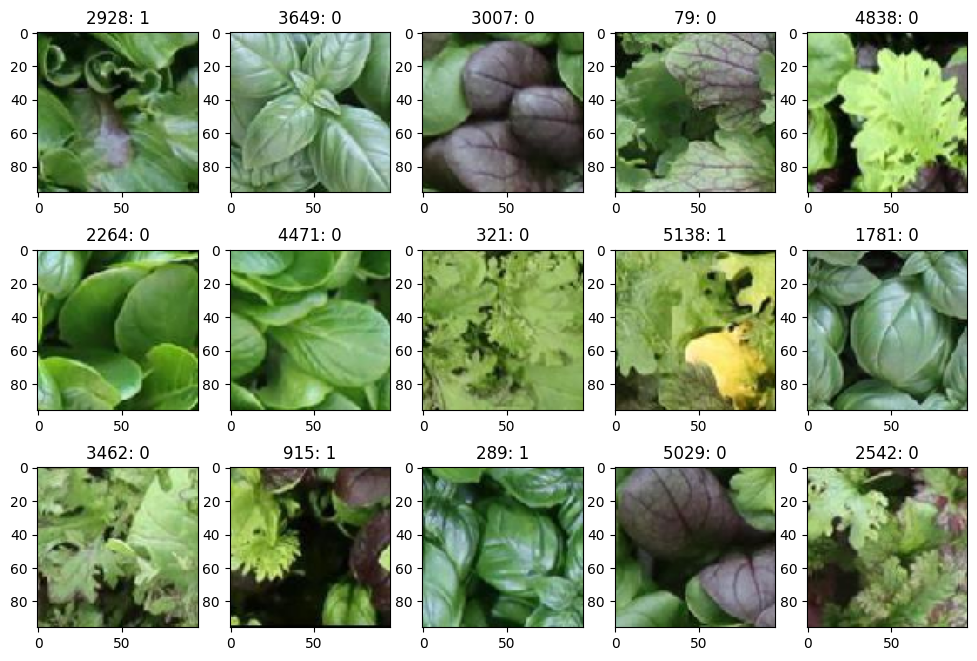

In [ ]:
plt.figure(figsize=(12, 8))
for i in range(15):
  rand= np.random.choice(range(len(images)))

  plt.subplot(3, 5, i + 1)
  plt.imshow(images[rand], cmap='gray')
  plt.title(str(rand) + ": " + str(labels[rand]))

# Display the images
plt.show()

Cleaning the dataset from images not inerent of the dataset (some ids of the dirt dataset are: `TROLOLO = 1988, SHREK = 138`)

In [ ]:
images, labels = zip(*[(images[i], labels[i]) for i in range(len(labels)) if not np.array_equal(images[138],images[i]) and not np.array_equal(images[1988],images[i])])

print(len(images))
print(len(labels))

5004
5004


Removing duplicates from the dataset

In [ ]:
images, labels = zip(*[(images[i], labels[i]) for i in range(len(labels)) if all(not np.array_equal(images[i], images[j]) for j in range(i))])
print(len(images))
print(len(labels))

4850
4850


Saving the images and labels into .npz file in order to not run every time the code for downloading, cleaning, and saving into variables the images and labels

In [ ]:
tf.io.gfile.makedirs(data_path)
np.savez_compressed(os.path.join(data_path, "all.npz"), image=images, label=labels)

# Data retrieval and balancing of classes

### Data retrieval from file and printing useful information

Getting the data from the .npz file

In [ ]:
data = np.load(os.path.join(data_path, 'all.npz'), allow_pickle=True)
# Print the keys in the .npz file
print("Keys in the .npz file:", list(data.keys()))

X = data['image']
y = data['label']

Keys in the .npz file: ['image', 'label']


Plotting random images

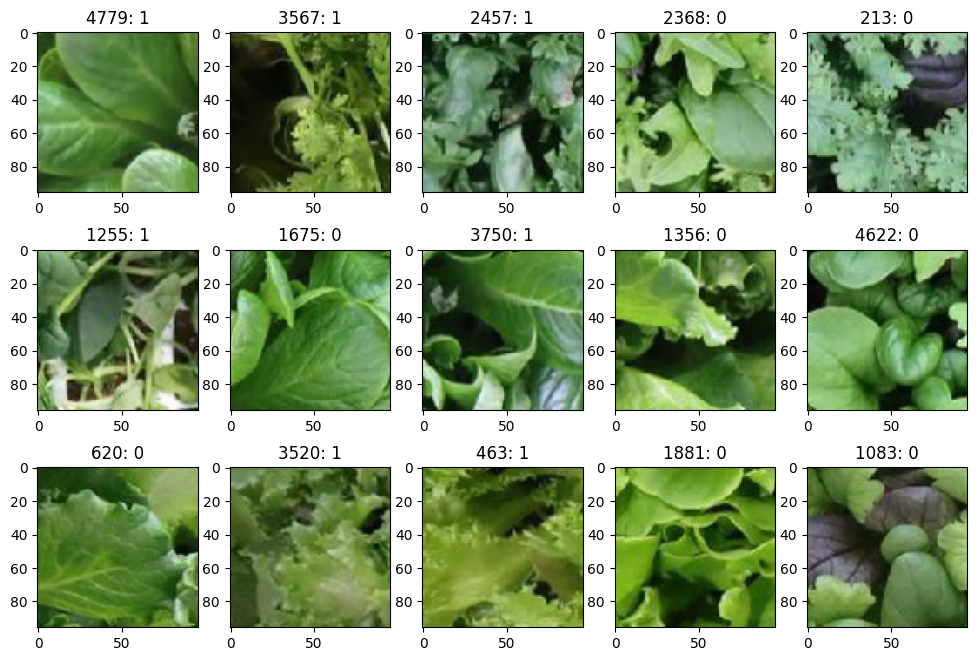

In [ ]:
plt.figure(figsize=(12, 8))
for i in range(15):
  rand= np.random.choice(range(len(X)))

  plt.subplot(3, 5, i + 1)
  plt.imshow(X[rand], cmap='gray')
  plt.title(str(rand) + ": " + str(y[rand]))

# Display the images
plt.show()

Splitting dataset in train and validation

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42, test_size=.20)

Plotting the unbalanced dataset

In [ ]:
printPie(y_train)

### Balancing techniques (choose only one technique)

#### Under Sampling


In [ ]:
X_train_flat = X_train.reshape(X_train.shape[0], -1)

# Create an instance of RandomUnderSampler
undersampler = RandomUnderSampler(random_state=42)

# Fit and transform the data to undersample the majority class
X_train_flat, y_train = undersampler.fit_resample(X_train_flat, y_train)

# If needed, reshape X_train_resampled_flat back to its original shape
X_train = X_train_flat.reshape(-1, *X_train.shape[1:])


#### Smote

Appling Smote for oversampling the dataset in order to balance it

In [ ]:
original_shape=X_train.shape[1:]
X_train = X_train.reshape(3880, 96 * 96 * 3)
smt = SMOTE()
X_train, y_train = smt.fit_resample(X_train, y_train)
X_train = X_train.reshape(-1, *original_shape)

#### **Class Weight**

In [ ]:
# Compute class weights
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
# Create a dictionary with class weights
class_weight_dict = dict(enumerate(class_weights))

### Last configuration and data visualization

Plotting the balanced dataset

In [ ]:
printPie(y_train)

Mapping the classes for the softmax (categorical)

In [ ]:
class_mapping = {
    0: [1, 0],
    1: [0, 1]
}
y_train = np.array([class_mapping[label] for label in y_train])
y_val = np.array([class_mapping[label] for label in y_val])

Plotting random images from the upsampled set

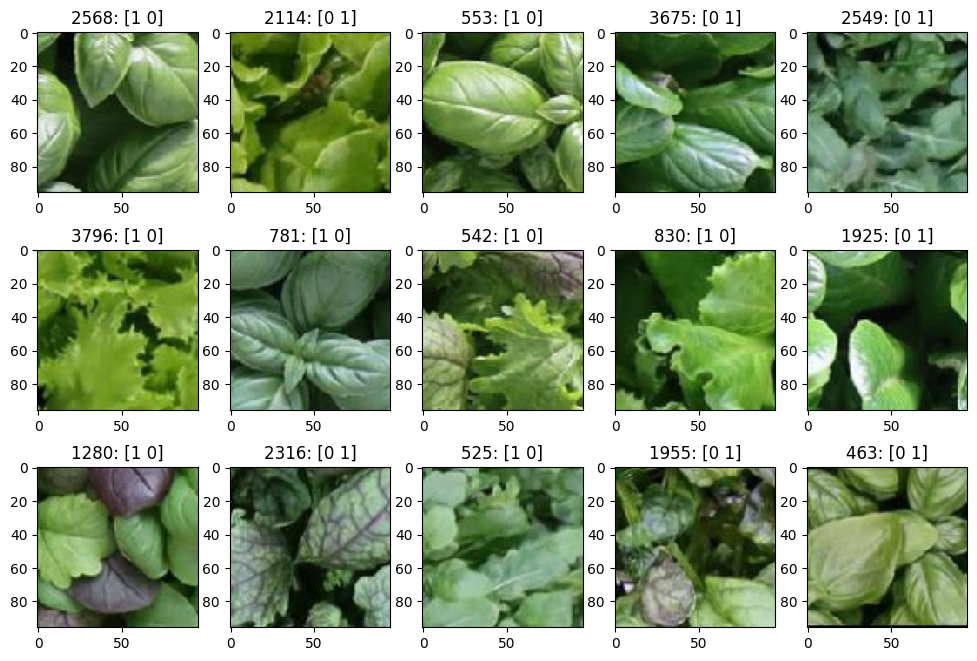

In [ ]:
plt.figure(figsize=(12, 8))
for i in range(15):
  rand= np.random.choice(range(len(X_train)))

  plt.subplot(3, 5, i + 1)
  plt.imshow(X_train[rand], cmap='gray')
  plt.title(str(rand) + ": " + str(y_train[rand]))

# Display the images
plt.show()

### Data Augmentation with conversion to unnormalized data

In [ ]:
augmenter = keras_cv.layers.Augmenter(
    [
        #keras_cv.layers.AutoContrast(value_range=(0,1)),
        keras_cv.layers.RandomFlip(),
        #keras_cv.layers.AugMix(),
        keras_cv.layers.CutMix(),
        keras_cv.layers.FourierMix(),
        #keras_cv.layers.ChannelShuffle(),
        #keras_cv.layers.GridMask(),
        #keras_cv.layers.JitteredResize(),
        #keras_cv.layers.MixUp(),
        #keras_cv.layers.RandAugment(),
        #keras_cv.layers.RandomAugmentationPipeline(),
        #keras_cv.layers.RandomChannelShift(),
        #keras_cv.layers.RandomColorDegeneration(0.2),
        #keras_cv.layers.RandomCutout(),
        #keras_cv.layers.RandomHue(),
        #keras_cv.layers.RandomSaturation(),
        #keras_cv.layers.RandomSharpness(),
        #keras_cv.layers.RandomShear(),
        #keras_cv.layers.Solarization()
    ],
)

def preprocess_data(images, labels, augment=False):
    inputs = {"images": images, "labels": labels}
    outputs = inputs
    if augment:
        outputs = augmenter(outputs)
    return outputs['images']*255, outputs['labels']

train_dataset = Dataset.from_tensor_slices((X_train, y_train))
val_dataset = Dataset.from_tensor_slices((X_val, y_val))

train_dataset = train_dataset.batch(32).map(
    lambda x, y: preprocess_data(x, y, augment=True),
        num_parallel_calls=tf.data.AUTOTUNE).prefetch(
            tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).map(
    preprocess_data, num_parallel_calls=tf.data.AUTOTUNE).prefetch(
        tf.data.AUTOTUNE)

Visualize some augmented images

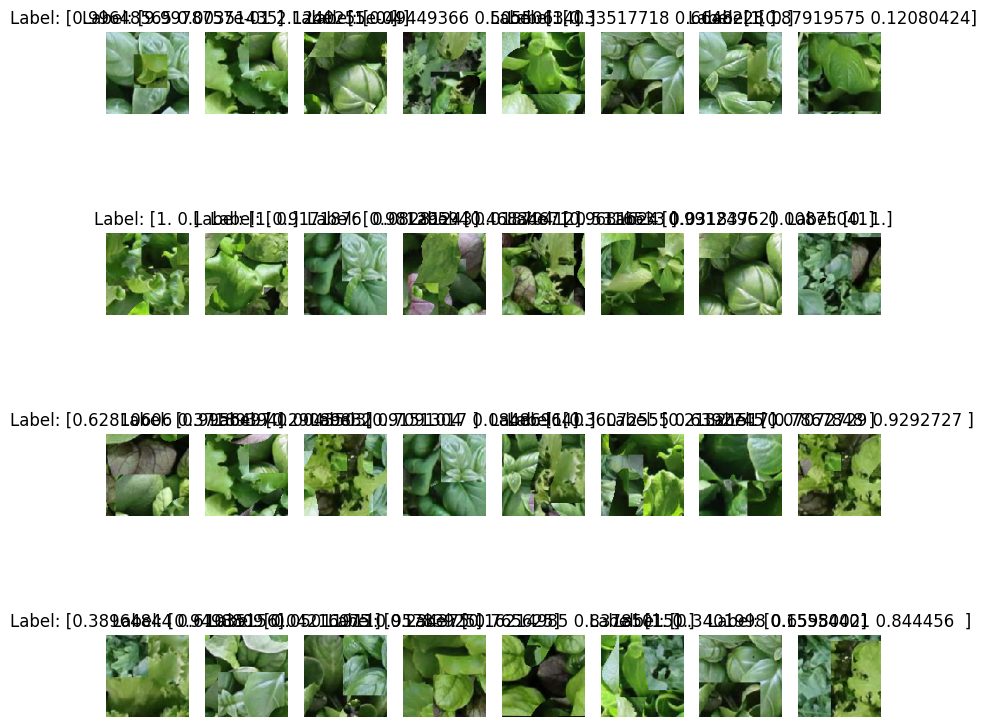

In [ ]:
# Function to visualize a batch of images
def show_images(images, labels):
    images=images
    plt.figure(figsize=(10, 10))
    for i in range(images.shape[0]):
        plt.subplot(4, 8, i + 1)
        plt.imshow(images[i])
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')
    plt.show()

# Get a batch of data from the dataset
for batch in train_dataset.take(1):  # Change 'train_dataset' to 'val_dataset' if needed
    images, labels = batch

# Visualize the augmented images
show_images(images/255, labels)

# Neural Networks:
Different Networks and their performance

## Model: Convolutional Neural Network
About this model:

* Uses a CNN Built from skretch
* Does augmentation to trainset

Defining the model

In [ ]:
model = models.Sequential([
  tfkl.Conv2D(16, (3, 3), activation='relu', input_shape=(96, 96, 3)),
  tfkl.MaxPooling2D((2, 2)),
  tfkl.Conv2D(32, (3, 3), activation='relu'),
  tfkl.MaxPooling2D((2, 2)),
  tfkl.Conv2D(64, (3, 3), activation='relu'),
  tfkl.MaxPooling2D((2, 2)),
  tfkl.Conv2D(128, (3, 3), activation='relu'),
  tfkl.GlobalAveragePooling2D(),
  tfkl.Dense(2, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer=AdamW(learning_rate=1e-4), metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 94, 94, 16)        448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 47, 47, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 22, 22, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 10, 10, 64)       

Callback for the fitting: EarlyStopping and Learning-Rate reduction

In [ ]:
callbacks=[tfk.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, mode='auto'),
           tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6, verbose=1, initial_lr=1e-4)]

Training the model

In [ ]:
model.fit(train_dataset, validation_data=val_dataset, epochs=1000, verbose=1, callbacks=callbacks, batch_size=32, class_weight=class_weight_dict)

Epoch 1/1000
122/122 [==============================] - 21s 146ms/step - loss: 1.0731 - accuracy: 0.5402 - val_loss: 1.2506 - val_accuracy: 0.3814 - lr: 1.0000e-04
Epoch 2/1000
122/122 [==============================] - 19s 152ms/step - loss: 0.8015 - accuracy: 0.5438 - val_loss: 0.6419 - val_accuracy: 0.6258 - lr: 1.0000e-04
Epoch 3/1000
122/122 [==============================] - 19s 154ms/step - loss: 0.7798 - accuracy: 0.5652 - val_loss: 0.8401 - val_accuracy: 0.4052 - lr: 1.0000e-04
Epoch 4/1000
122/122 [==============================] - 19s 154ms/step - loss: 0.8109 - accuracy: 0.5459 - val_loss: 0.8733 - val_accuracy: 0.3928 - lr: 1.0000e-04
Epoch 5/1000
122/122 [==============================] - 19s 153ms/step - loss: 0.7543 - accuracy: 0.5490 - val_loss: 0.6069 - val_accuracy: 0.6732 - lr: 1.0000e-04
Epoch 6/1000
122/122 [==============================] - 19s 152ms/step - loss: 0.7368 - accuracy: 0.5603 - val_loss: 0.6758 - val_accuracy: 0.6299 - lr: 1.0000e-04
Epoch 7/1000
122

Saves the model into the drive folder

In [ ]:
model.save(os.path.join(master_path, "models", "CNN"))

Print the confusion matrix

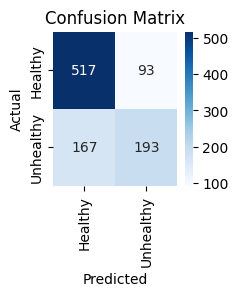

In [ ]:
generate_confusion_matrix(model, val_dataset)

Print the model structure

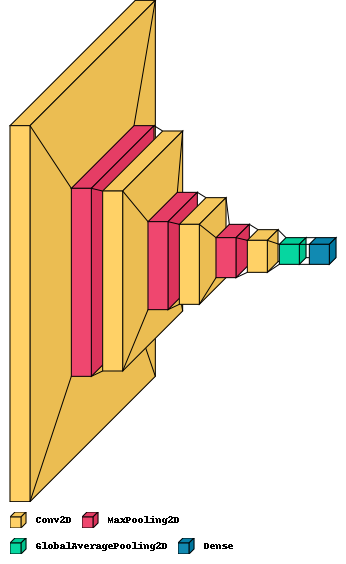

In [ ]:
visualkeras.layered_view(model, legend=True, font = font)

Deletes the model freeing the RAM

In [ ]:
del model

## Model: EfficientNetV2B3
About this model:

* Use the freezed pretrained EffeicientNetV2B3 model for Transfer Learning
* Uses a class weight balanced
* Does augmentation to dataset
* Unfreezes different layers for Fine Tuning
* Saves model





### Transfer Learning

Downloading the pre-trained model from Keras and freeze the layers for TransferLearning

In [ ]:
base_model = tf.keras.applications.EfficientNetV2B3(input_shape=(96,96,3), weights='imagenet', include_top=False, include_preprocessing=True)
base_model.trainable=False

Defining the model

In [ ]:
def model(dropout_rate):
    model = models.Sequential([
        base_model,
        tfkl.GlobalAveragePooling2D(),
        tfkl.Dense(256, activation="relu"),
        tfkl.BatchNormalization(),
        tfkl.Dropout(dropout_rate),
        tfkl.Dense(128, activation="relu"),
        tfkl.BatchNormalization(),
        tfkl.Dropout(dropout_rate),
        tfkl.Dense(2, activation="softmax")
    ])

    model.compile(loss='categorical_crossentropy', optimizer=AdamW(learning_rate=1e-4), metrics=['accuracy'])

    return model

The model with the defined dropout

In [ ]:
model = model(0.5)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b3 (Functio  (None, 3, 3, 1536)        12930622  
 nal)                                                            
                                                                 
 global_average_pooling2d_2  (None, 1536)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 256)               393472    
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                      

Callback for the fitting: EarlyStopping and Learning-Rate reduction




In [ ]:
callbacks=[tfk.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, mode='auto'),
           tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6, verbose=1, initial_lr=1e-4)]

Train of the model

In [ ]:
model.fit(train_dataset, validation_data=val_dataset, epochs=1000, verbose=1, callbacks=callbacks, batch_size=32, class_weight=class_weight_dict)

Epoch 1/1000
122/122 [==============================] - 43s 212ms/step - loss: 1.2572 - accuracy: 0.5294 - val_loss: 0.6123 - val_accuracy: 0.6887 - lr: 1.0000e-04
Epoch 2/1000
122/122 [==============================] - 21s 172ms/step - loss: 1.1711 - accuracy: 0.5425 - val_loss: 0.5656 - val_accuracy: 0.7299 - lr: 1.0000e-04
Epoch 3/1000
122/122 [==============================] - 21s 172ms/step - loss: 1.1306 - accuracy: 0.5271 - val_loss: 0.5610 - val_accuracy: 0.7113 - lr: 1.0000e-04
Epoch 4/1000
122/122 [==============================] - 21s 168ms/step - loss: 1.0677 - accuracy: 0.5456 - val_loss: 0.5223 - val_accuracy: 0.7495 - lr: 1.0000e-04
Epoch 5/1000
122/122 [==============================] - 21s 173ms/step - loss: 1.0172 - accuracy: 0.5528 - val_loss: 0.5074 - val_accuracy: 0.7577 - lr: 1.0000e-04
Epoch 6/1000
122/122 [==============================] - 21s 168ms/step - loss: 0.9806 - accuracy: 0.5631 - val_loss: 0.5140 - val_accuracy: 0.7454 - lr: 1.0000e-04
Epoch 7/1000
122

Saving the model

In [ ]:
model.save(os.path.join(master_path, "models", "EfficientNetV2B3-TL"))

Deletes the model freeing the RAM

In [ ]:
del model

### Fine Tuning

Load and check of the model

In [ ]:
model = tfk.models.load_model(os.path.join(master_path, "models", "EfficientNetV2B3-TL"))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b3 (Functio  (None, 3, 3, 1536)        12930622  
 nal)                                                            
                                                                 
 global_average_pooling2d_2  (None, 1536)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 256)               393472    
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                      

Function that unfreeze `N/4` layers of the pretrained model




In [ ]:
pt_model_name=model.layers[0].name

def unfreeze_model(modello, N_layers):
  model = modello
  for i, layer in enumerate(model.get_layer(pt_model_name).layers[-N_layers:]):
    if isinstance(layer, tfkl.BatchNormalization):
      layer.trainable = False
    else:
      layer.trainable=True

  print("Unfeezed the last " + str(N_layers) + " of the model, excluded the BatchNormalization ones")
  model.compile(loss='categorical_crossentropy', optimizer=AdamW(), metrics=['accuracy'])
  return model

num_layers=len(model.get_layer(pt_model_name).layers)//4

model = unfreeze_model(model, num_layers)

Unfeezed the last 102 of the model, excluded the BatchNormalization ones


Callback for the fitting: EarlyStopping and learning-rate reduction

In [ ]:
callbacks=[tfk.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, mode='auto'),
           tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1, initial_lr=1e-4)]

Train of the model

In [ ]:
model.fit(train_dataset, validation_data=val_dataset, epochs=1000, verbose=1, callbacks=callbacks, batch_size=32, class_weight=class_weight_dict)

Epoch 1/1000
122/122 [==============================] - 38s 198ms/step - loss: 0.8085 - accuracy: 0.5724 - val_loss: 0.5231 - val_accuracy: 0.7588 - lr: 0.0010
Epoch 2/1000
122/122 [==============================] - 22s 180ms/step - loss: 0.7132 - accuracy: 0.5966 - val_loss: 0.5320 - val_accuracy: 0.7598 - lr: 0.0010
Epoch 3/1000
122/122 [==============================] - 21s 172ms/step - loss: 0.6853 - accuracy: 0.6113 - val_loss: 0.5098 - val_accuracy: 0.7804 - lr: 0.0010
Epoch 4/1000
122/122 [==============================] - 21s 170ms/step - loss: 0.6592 - accuracy: 0.6433 - val_loss: 0.5161 - val_accuracy: 0.7732 - lr: 0.0010
Epoch 5/1000
122/122 [==============================] - 21s 172ms/step - loss: 0.6425 - accuracy: 0.6668 - val_loss: 0.4965 - val_accuracy: 0.7907 - lr: 0.0010
Epoch 6/1000
122/122 [==============================] - 22s 176ms/step - loss: 0.6568 - accuracy: 0.6523 - val_loss: 0.5016 - val_accuracy: 0.8041 - lr: 0.0010
Epoch 7/1000
122/122 [==================

Saves the model into the drive folder

In [ ]:
model.save(os.path.join(master_path, "models", "EfficientNetV2B3"))

Print the confusion matrix

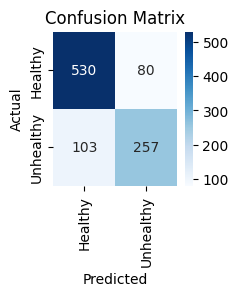

In [ ]:
generate_confusion_matrix(model, val_dataset)

Print the model structure

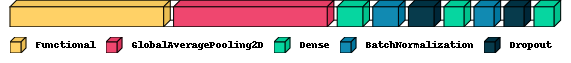

In [ ]:
visualkeras.layered_view(model, legend=True, font = font)

Deletes the model freeing the RAM

In [ ]:
del model

## Model ConvNeXtXBase:
About this model:

* Use the freezed pretrained ConvNeXtXBase model for Transfer Learning
* Uses a class weight balanced
* Does augmentation to dataset
* Unfreezes different layers for Fine Tuning
* Saves model

### Transfer Learning

Downloading the pre-trained model from Keras and freeze the layers for TransferLearning

In [ ]:
base_model = tf.keras.applications.ConvNeXtBase(input_shape=(96,96,3), weights='imagenet', include_top=False, include_preprocessing=True)
base_model.trainable=False

350926856/350926856 [==============================] - 6s 0us/step


Defining the model

In [ ]:
def model(dropout_rate):
    model = models.Sequential([
        base_model,
        tfkl.GlobalAveragePooling2D(),
        tfkl.Dense(256, activation="relu"),
        tfkl.BatchNormalization(),
        tfkl.Dropout(dropout_rate),
        tfkl.Dense(128, activation="relu"),
        tfkl.BatchNormalization(),
        tfkl.Dropout(dropout_rate),
        tfkl.Dense(2, activation="softmax")
    ])

    model.compile(loss='categorical_crossentropy', optimizer=AdamW(learning_rate=1e-4), metrics=['accuracy'])

    return model

The model with the defined dropout

In [ ]:
model = model(0.5)
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 convnext_base (Functional)  (None, 3, 3, 1024)        87566464  
                                                                 
 global_average_pooling2d_3  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_5 (Dense)             (None, 256)               262400    
                                                                 
 batch_normalization_2 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 128)              

Callback for the fitting: EarlyStopping and Learning-Rate reduction

In [ ]:
callbacks=[tfk.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, mode='auto'),
           tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6, verbose=1, initial_lr=1e-4)]

Train of the model

In [ ]:
model.fit(train_dataset, validation_data=val_dataset, epochs=4000, verbose=1, callbacks=callbacks, batch_size=32)

Epoch 1/4000
122/122 [==============================] - 76s 442ms/step - loss: 1.2075 - accuracy: 0.5268 - val_loss: 0.6734 - val_accuracy: 0.6103 - lr: 1.0000e-04
Epoch 2/4000
122/122 [==============================] - 29s 240ms/step - loss: 1.1383 - accuracy: 0.5399 - val_loss: 0.5760 - val_accuracy: 0.6928 - lr: 1.0000e-04
Epoch 3/4000
122/122 [==============================] - 32s 257ms/step - loss: 1.0415 - accuracy: 0.5688 - val_loss: 0.5339 - val_accuracy: 0.7402 - lr: 1.0000e-04
Epoch 4/4000
122/122 [==============================] - 29s 238ms/step - loss: 1.0185 - accuracy: 0.5742 - val_loss: 0.5055 - val_accuracy: 0.7567 - lr: 1.0000e-04
Epoch 5/4000
122/122 [==============================] - 31s 253ms/step - loss: 0.9393 - accuracy: 0.5910 - val_loss: 0.4955 - val_accuracy: 0.7608 - lr: 1.0000e-04
Epoch 6/4000
122/122 [==============================] - 28s 228ms/step - loss: 0.9259 - accuracy: 0.5948 - val_loss: 0.4909 - val_accuracy: 0.7515 - lr: 1.0000e-04
Epoch 7/4000
122

Saving the model

In [ ]:
model.save(os.path.join(master_path, "models", "ConvNeXtBase-TL"))

Deletes the model freeing the RAM

In [ ]:
del model

### Fine Tuning

Load and check of the model

In [ ]:
model = tfk.models.load_model(os.path.join(master_path, "models", "ConvNeXtBase-TL"))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 convnext_base (Functional)  (None, 3, 3, 1024)        87566464  
                                                                 
 global_average_pooling2d_3  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_5 (Dense)             (None, 256)               262400    
                                                                 
 batch_normalization_2 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 128)              

Function that unfreeze `N/4` layers of the pretrained model

In [ ]:
pt_model_name=model.layers[0].name

def unfreeze_model(modello, N_layers):
  model = modello
  for i, layer in enumerate(model.get_layer(pt_model_name).layers[-N_layers:]):
    if isinstance(layer, tfkl.BatchNormalization):
      layer.trainable = False
    else:
      layer.trainable=True

  print("Unfeezed the last " + str(N_layers) + " of the model, excluded the BatchNormalization ones")
  model.compile(loss='categorical_crossentropy', optimizer=AdamW(), metrics=['accuracy'])
  return model

num_layers=len(model.get_layer(pt_model_name).layers)//4

model = unfreeze_model(model, num_layers)

Unfeezed the last 73 of the model, excluded the BatchNormalization ones


Callback for the fitting: EarlyStopping and Learning-Rate reduction

In [ ]:
callbacks=[tfk.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, mode='auto'),
           tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1, initial_lr=1e-4)]

Train of the model

In [ ]:
model.fit(train_dataset, validation_data=val_dataset, epochs=4000, verbose=1, callbacks=callbacks, batch_size=32)

Epoch 1/4000
122/122 [==============================] - 69s 349ms/step - loss: 0.7481 - accuracy: 0.6196 - val_loss: 0.4936 - val_accuracy: 0.7639 - lr: 0.0010
Epoch 2/4000
122/122 [==============================] - 29s 240ms/step - loss: 0.6607 - accuracy: 0.6536 - val_loss: 0.5157 - val_accuracy: 0.7474 - lr: 0.0010
Epoch 3/4000
122/122 [==============================] - 32s 263ms/step - loss: 0.6298 - accuracy: 0.6776 - val_loss: 0.4716 - val_accuracy: 0.7598 - lr: 0.0010
Epoch 4/4000
122/122 [==============================] - 29s 233ms/step - loss: 0.6145 - accuracy: 0.6899 - val_loss: 0.4589 - val_accuracy: 0.7866 - lr: 0.0010
Epoch 5/4000
122/122 [==============================] - 32s 257ms/step - loss: 0.6143 - accuracy: 0.6972 - val_loss: 0.4658 - val_accuracy: 0.7773 - lr: 0.0010
Epoch 6/4000
122/122 [==============================] - 29s 238ms/step - loss: 0.6131 - accuracy: 0.6912 - val_loss: 0.4397 - val_accuracy: 0.7907 - lr: 0.0010
Epoch 7/4000
122/122 [==================

Saving the model

In [ ]:
model.save(os.path.join(master_path, "models", "ConvNeXtBase"))

Print the confusion matrix

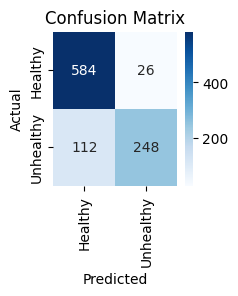

In [ ]:
generate_confusion_matrix(model, val_dataset)

Print the model structure

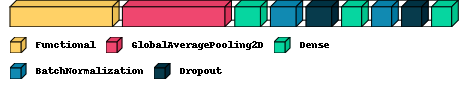

In [ ]:
visualkeras.layered_view(model, legend=True, font = font)

Deletes the model freeing the RAM

In [ ]:
del model

## Model: ConvNeXtXLarge
About this model:

* Use the freezed pretrained ConvNeXtXLarge model for Transfer Learning
* Uses a class weight balanced
* Does augmentation to dataset
* Unfreezes different layers for Fine Tuning
* Saves model

### Transfer Learning

Downloading the pre-trained model from Keras and freeze the layers for TransferLearning

In [ ]:
base_model = tf.keras.applications.ConvNeXtXLarge(input_shape=(96,96,3), weights='imagenet', include_top=False, include_preprocessing=True)
base_model.trainable = False

1393257616/1393257616 [==============================] - 8s 0us/step


Defining the model

In [ ]:
def model(dropout_rate):
    model = models.Sequential([
        base_model,
        tfkl.GlobalAveragePooling2D(),
        tfkl.Dense(256, activation="relu"),
        tfkl.BatchNormalization(),
        tfkl.Dropout(dropout_rate),
        tfkl.Dense(128, activation="relu"),
        tfkl.BatchNormalization(),
        tfkl.Dropout(dropout_rate),
        tfkl.Dense(2, activation="softmax")
    ])

    model.compile(loss='categorical_crossentropy', optimizer=AdamW(learning_rate=1e-4), metrics=['accuracy'])

    return model

The model with the defined dropout

In [ ]:
model = model(0.0)
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 convnext_xlarge (Functiona  (None, 3, 3, 2048)        348147968 
 l)                                                              
                                                                 
 global_average_pooling2d_4  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_8 (Dense)             (None, 256)               524544    
                                                                 
 batch_normalization_4 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                      

Callback for the fitting: EarlyStopping and Learning-Rate reduction

In [ ]:
callbacks=[tfk.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, mode='auto'),
           tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6, verbose=1, initial_lr=1e-4)]

Train of the model

In [ ]:
model.fit(train_dataset, validation_data=val_dataset, epochs=4000, verbose=1, callbacks=callbacks, batch_size=32, class_weight=class_weight_dict)

Epoch 1/4000
122/122 [==============================] - 98s 618ms/step - loss: 0.8782 - accuracy: 0.5559 - val_loss: 0.5639 - val_accuracy: 0.7206 - lr: 1.0000e-04
Epoch 2/4000
122/122 [==============================] - 54s 437ms/step - loss: 0.7406 - accuracy: 0.6162 - val_loss: 0.5042 - val_accuracy: 0.7629 - lr: 1.0000e-04
Epoch 3/4000
122/122 [==============================] - 54s 437ms/step - loss: 0.6851 - accuracy: 0.6528 - val_loss: 0.4586 - val_accuracy: 0.7845 - lr: 1.0000e-04
Epoch 4/4000
122/122 [==============================] - 52s 425ms/step - loss: 0.6690 - accuracy: 0.6608 - val_loss: 0.4604 - val_accuracy: 0.7722 - lr: 1.0000e-04
Epoch 5/4000
122/122 [==============================] - 54s 437ms/step - loss: 0.6565 - accuracy: 0.6722 - val_loss: 0.4370 - val_accuracy: 0.8103 - lr: 1.0000e-04
Epoch 6/4000
122/122 [==============================] - 53s 435ms/step - loss: 0.6529 - accuracy: 0.6691 - val_loss: 0.4201 - val_accuracy: 0.8247 - lr: 1.0000e-04
Epoch 7/4000
122

Saving the model

In [ ]:
model.save(os.path.join(master_path, "models", "ConvNeXtXLarge-TL"))

Deletes the model freeing the RAM

In [ ]:
del model

### Fine Tuning

Load and check of the model

In [ ]:
model = tfk.models.load_model(os.path.join(master_path, "models", "ConvNeXtXLarge-TL"))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 convnext_xlarge (Functiona  (None, 3, 3, 2048)        348147968 
 l)                                                              
                                                                 
 global_average_pooling2d_4  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_8 (Dense)             (None, 256)               524544    
                                                                 
 batch_normalization_4 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                      

Function that unfreeze `N/4` layers of the pretrained model

In [ ]:
pt_model_name=model.layers[0].name

def unfreeze_model(modello, N_layers):
  model = modello
  for i, layer in enumerate(model.get_layer(pt_model_name).layers[-N_layers:]):
    if isinstance(layer, tfkl.BatchNormalization):
      layer.trainable = False
    else:
      layer.trainable=True

  print("Unfeezed the last " + str(N_layers) + " of the model, excluded the BatchNormalization ones")
  model.compile(loss='categorical_crossentropy', optimizer=AdamW(), metrics=['accuracy'])
  return model

num_layers=len(model.get_layer(pt_model_name).layers)//4

model = unfreeze_model(model, num_layers)

Unfeezed the last 73 of the model, excluded the BatchNormalization ones


Callback for the fitting: EarlyStopping and learning-rate reduction

In [ ]:
callbacks=[tfk.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, mode='auto'),
           tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5, verbose=1, initial_lr=1e-4)]

Train of the model

In [ ]:
model.fit(train_dataset, validation_data=val_dataset, epochs=1000, verbose=1, callbacks=callbacks, batch_size=32, class_weight=class_weight_dict)

Epoch 1/1000
122/122 [==============================] - 101s 550ms/step - loss: 0.6884 - accuracy: 0.6526 - val_loss: 0.5979 - val_accuracy: 0.7216 - lr: 0.0010
Epoch 2/1000
122/122 [==============================] - 53s 432ms/step - loss: 0.6520 - accuracy: 0.6711 - val_loss: 0.4258 - val_accuracy: 0.8052 - lr: 0.0010
Epoch 3/1000
122/122 [==============================] - 53s 431ms/step - loss: 0.6277 - accuracy: 0.6933 - val_loss: 0.4059 - val_accuracy: 0.8371 - lr: 0.0010
Epoch 4/1000
122/122 [==============================] - 53s 430ms/step - loss: 0.6177 - accuracy: 0.7116 - val_loss: 0.4127 - val_accuracy: 0.8206 - lr: 0.0010
Epoch 5/1000
122/122 [==============================] - 53s 431ms/step - loss: 0.6182 - accuracy: 0.6997 - val_loss: 0.4118 - val_accuracy: 0.8423 - lr: 0.0010
Epoch 6/1000
122/122 [==============================] - 53s 430ms/step - loss: 0.6113 - accuracy: 0.7041 - val_loss: 0.4110 - val_accuracy: 0.8330 - lr: 0.0010
Epoch 7/1000
122/122 [=================

Saving the model

In [ ]:
model.save(os.path.join(master_path, "models", "ConvNeXtXLarge"))

Print the confusion matrix

In [ ]:
generate_confusion_matrix(model, val_dataset)

Print the model structure

In [ ]:
visualkeras.layered_view(model, legend=True, font = font)

Deletes the model freeing the RAM

In [ ]:
del model